In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed May 11 18:54:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Imports

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

Find Normalization

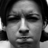

In [4]:
img_path = '../content/drive/MyDrive/Colab Notebooks/CK+/train/anger/S010_004_00000017.png'
img = Image.open(img_path)
display(img)

In [5]:
img_np = np.array(img)

Text(0.5, 1.0, 'distribution of pixels')

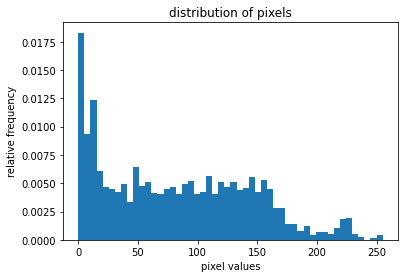

In [6]:
plt.hist(img_np.ravel(), bins=50, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels")

In [7]:
transform_img = transforms.Compose([
    transforms.ToTensor()
])

In [8]:
img_tr = transform_img(img)
  
img_np = np.array(img_tr)

Text(0.5, 1.0, 'distribution of pixels')

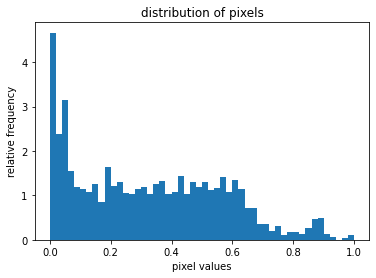

In [9]:
plt.hist(img_np.ravel(), bins=50, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels")

In [10]:
mean, std = img_tr.mean([1,2]), img_tr.std([1,2])

In [11]:
print("mean and std before normalize:")
print("Mean of the image:", mean)
print("Std of the image:", std)

mean and std before normalize:
Mean of the image: tensor([0.3234])
Std of the image: tensor([0.2422])


Visualization

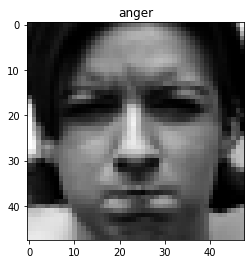

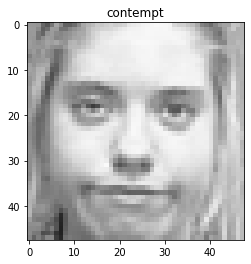

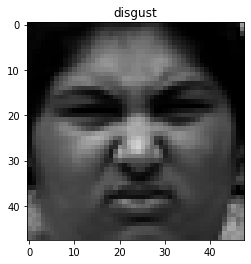

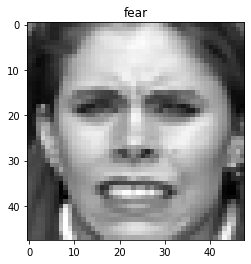

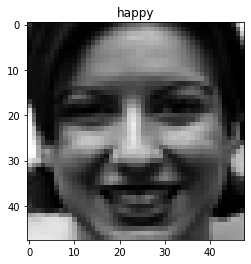

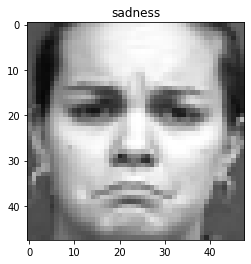

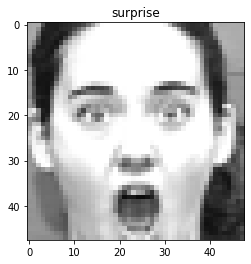

In [12]:
# Visualize one image from each category of the dataset

data_dir = ('../content/drive/MyDrive/Colab Notebooks/CK+/train/')
categories = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']
for i in categories:
    path = os.path.join(data_dir, i)
    num = 0
    
    for img in os.listdir(path):
        
        if num == 1:
            break
        
        else:
            img_array = cv2.imread(os.path.join(path,img))
            img_array = cv2.resize(img_array, (48, 48))
            plt.imshow(img_array)
            plt.title(i)
            plt.show()
            num +=1

In [13]:
image_files = os.listdir(path)
image = os.path.join(path, image_files[0])
image = cv2.imread(image)
image.shape

(48, 48, 3)

Transformations

In [14]:
from torchvision.transforms.transforms import RandomHorizontalFlip
train_transform = transforms.Compose([
      # transforms.CenterCrop(40),
      # transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      # transforms.Pad(15),
      # transforms.Resize(48),
      transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
      # transforms.CenterCrop(40),
      transforms.ToTensor(),
      # transforms.Pad(15),
      # transforms.Resize(48),
      transforms.Normalize(mean, std)
])

Datasets

In [15]:
root = '../content/drive/MyDrive/Colab Notebooks/CK+/'

train_data = datasets.ImageFolder(os.path.join(root, 'train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root, 'test'), transform=test_transform)

In [16]:
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 735
     Root location: ../content/drive/MyDrive/Colab Notebooks/CK+/train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=tensor([0.3234]), std=tensor([0.2422]))
            ), Dataset ImageFolder
     Number of datapoints: 246
     Root location: ../content/drive/MyDrive/Colab Notebooks/CK+/test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=tensor([0.3234]), std=tensor([0.2422]))
            ))

Load Data

In [17]:
torch.manual_seed(1234)
train_loader = DataLoader(train_data, batch_size=25, shuffle=True)
test_loader = DataLoader(test_data, batch_size=25, shuffle=True)

class_names = train_data.classes

In [18]:
print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')

['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']
Training images available: 735
Testing images available:  246


Display a batch of image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([25, 3, 48, 48])
Label: [2 4 4 2 4 1 0 4 2 3 2 2 4 2 3 0 3 5 0 0 4 4 6 6 2]
Class: disgust happy happy disgust happy contempt anger happy disgust fear disgust disgust happy disgust fear anger fear sadness anger anger happy happy surprise surprise disgust


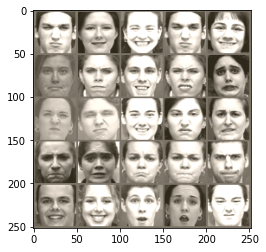

In [19]:
# Grab the first batch of 10 images
for images,labels in train_loader: 
    break

print(images.shape)
# Print the labels
print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=5)  # the default nrow is 8

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Print the images
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

Check the Shape

In [20]:
conv1 = nn.Conv2d(3, 16, 3, 1)
conv2 = nn.Conv2d(16, 64, 3, 1)

In [21]:
# Grab the first record
for i, (X_train, y_train) in enumerate(train_data):
    break

In [22]:
# Create a rank-4 tensor to be passed into the model
# (train_loader will have done this already)
x = X_train.view(1, 3, 48, 48)
print(x.shape)

torch.Size([1, 3, 48, 48])


In [23]:
x

tensor([[[[-0.9467, -1.1733, -1.1247,  ..., -0.7686,  1.3035,  2.6795],
          [-1.0600, -1.1895, -1.0600,  ..., -1.1085,  0.2998,  2.4691],
          [-1.1733, -1.1409, -1.0600,  ..., -1.2704, -0.6391,  1.9187],
          ...,
          [ 2.2586,  2.2910,  2.2910,  ...,  1.1578,  1.1740,  1.2226],
          [ 2.3558,  2.3720,  2.3720,  ...,  1.1255,  1.1740,  1.2226],
          [ 2.4529,  2.4691,  2.4367,  ...,  1.0931,  1.1416,  1.1902]],

         [[-0.9467, -1.1733, -1.1247,  ..., -0.7686,  1.3035,  2.6795],
          [-1.0600, -1.1895, -1.0600,  ..., -1.1085,  0.2998,  2.4691],
          [-1.1733, -1.1409, -1.0600,  ..., -1.2704, -0.6391,  1.9187],
          ...,
          [ 2.2586,  2.2910,  2.2910,  ...,  1.1578,  1.1740,  1.2226],
          [ 2.3558,  2.3720,  2.3720,  ...,  1.1255,  1.1740,  1.2226],
          [ 2.4529,  2.4691,  2.4367,  ...,  1.0931,  1.1416,  1.1902]],

         [[-0.9467, -1.1733, -1.1247,  ..., -0.7686,  1.3035,  2.6795],
          [-1.0600, -1.1895, -

In [24]:
# Perform the first convolution/activation
x = F.relu(conv1(x))
x.shape

torch.Size([1, 16, 46, 46])

In [25]:
# Run the first pooling layer
x = F.max_pool2d(x, 2, 2)
print(x.shape)

torch.Size([1, 16, 23, 23])


In [26]:
# Perform the second convolution/activation
x = F.relu(conv2(x))
print(x.shape)

torch.Size([1, 64, 21, 21])


In [27]:
# Run the second pooling layer
x = F.max_pool2d(x, 2, 2)
print(x.shape)

torch.Size([1, 64, 10, 10])


In [28]:
# Flatten the data
x = x.view(-1, 64*10*10)
print(x.shape)

torch.Size([1, 6400])


CNN Model

In [29]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 64, 3, 1)
        self.dr = nn.Dropout(0.2)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(10*10*64, 410)
        self.fc2 = nn.Linear(410, 7)
        self.bnc1 = nn.BatchNorm1d(410)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = self.bn1(X)
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = self.bn2(X)
        X = self.dr(X)
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 64*10*10)
        X = F.relu(self.fc1(X))
        X = self.bnc1(X)
        X = self.fc2(X)
        X = self.dr(X)
        return F.log_softmax(X, dim=1)

Define Loss and Optimizer

In [30]:
torch.manual_seed(1234)
CNNmodel = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(CNNmodel.parameters(), lr=0.001)

In [31]:
CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
  (dr): Dropout(p=0.2, inplace=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=6400, out_features=410, bias=True)
  (fc2): Linear(in_features=410, out_features=7, bias=True)
  (bnc1): BatchNorm1d(410, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

Count Trainable Parameters

In [32]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')

In [33]:
count_parameters(CNNmodel)

     432
      16
    9216
      64
      16
      16
      64
      64
 2624000
     410
    2870
       7
     410
     410
________
 2637995


Train the model

In [34]:
import time
start_time = time.time()

epochs = 50

max_trn_batch = 30
max_tst_batch = 10

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    CNNmodel.train()
    for b, (X_train, y_train) in enumerate(train_loader):
        
        # Limit the number of batches
        if b == max_trn_batch:
            break
        b+=1
        
        # Apply the model
        y_pred = CNNmodel(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%10 == 0 or b>=36:
            acc = trn_corr.item()*100/(25*b)
            print(f'epoch: {i+1:2}  batch: {b:4}  loss: {loss.item():10.8f}  accuracy: {acc:7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    CNNmodel.eval()
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            # Limit the number of batches
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = CNNmodel(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  1  batch:   10  loss: 1.09983897  accuracy:  51.200%
epoch:  1  batch:   20  loss: 0.61339307  accuracy:  59.200%
epoch:  1  batch:   30  loss: 0.91766244  accuracy:  64.000%
epoch:  2  batch:   10  loss: 0.27650908  accuracy:  80.400%
epoch:  2  batch:   20  loss: 0.46208015  accuracy:  80.800%
epoch:  2  batch:   30  loss: 0.55871105  accuracy:  77.867%
epoch:  3  batch:   10  loss: 0.32461545  accuracy:  82.800%
epoch:  3  batch:   20  loss: 0.34059644  accuracy:  83.000%
epoch:  3  batch:   30  loss: 0.40468138  accuracy:  80.800%
epoch:  4  batch:   10  loss: 0.44730514  accuracy:  85.200%
epoch:  4  batch:   20  loss: 0.37163940  accuracy:  83.600%
epoch:  4  batch:   30  loss: 0.29357991  accuracy:  81.067%
epoch:  5  batch:   10  loss: 0.39035174  accuracy:  84.000%
epoch:  5  batch:   20  loss: 0.24533626  accuracy:  85.600%
epoch:  5  batch:   30  loss: 0.21288809  accuracy:  85.467%
epoch:  6  batch:   10  loss: 0.30248532  accuracy:  84.800%
epoch:  6  batch:   20  

Plot loss and accuracy

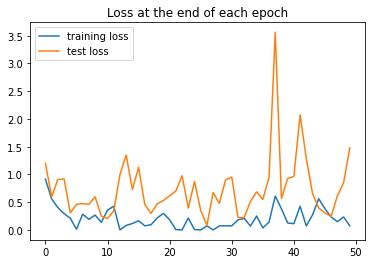

In [35]:
train_loss = [fl.item() for fl in train_losses]
test_loss = [fl.item() for fl in test_losses]
plt.plot(train_loss, label='training loss')
plt.plot(test_loss, label='test loss')
plt.title('Loss at the end of each epoch')
plt.legend()

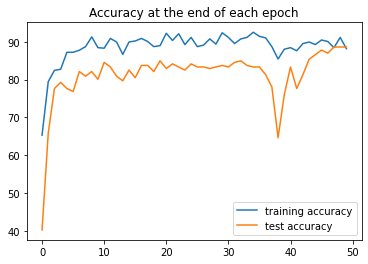

In [36]:
plt.plot([t*100/735 for t in train_correct], label='training accuracy')
plt.plot([t*100/246 for t in test_correct], label='test accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend()

Evaluate test data

In [37]:
test_load_all = DataLoader(test_data, batch_size=246, shuffle=False)
CNNmodel.eval()
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = CNNmodel(X_test)  
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 218/246 =  88.618%
